In [2]:
import os
import numpy as np
from tqdm import tqdm
from timeit import default_timer
import matplotlib.pyplot as plt
import argparse
import yaml
import xarray as xr

import torch
from torch.utils.data import DataLoader, random_split
from utils import *

from dataset import *
from metrics import *
import sys
import csv

## 绘图：201901不同深度预测结果

res, pred, info = model.train_one_step(inputs, targets, mask, minmax, calculate_res, metric_names)

res: [1, 1, depth]

pred: [1, depth, lat, lon]

In [22]:
# test 201901 - 绘图
# test_loader中为25个月份的每月数据
def plot_temperature_at_depth(pred, i, latitude=[0, 0], longitude=[0, 0], vmin=2, vmax=10):
    """
    绘制特定深度的海水温度图，并固定颜色刻度范围。
    
    参数：
    - pred: 3D numpy 数组，大小为 [depth, lat, lon]，表示温度数据
    - i: 整数，表示要绘制的深度索引
    - vmin: 最小温度值，颜色刻度的下限
    - vmax: 最大温度值，颜色刻度的上限
    
    返回：
    - 绘制指定深度的温度分布图
    """
    # 检查深度索引是否在范围内
    if i < 0 or i >= pred.shape[0]:
        raise ValueError(f"深度索引 i 超出范围，应在 0 到 {pred.shape[0] - 1} 之间")
    
    # 获取指定深度的温度数据
    temperature_at_depth = pred[i, :, :]
    
    # 生成经纬度坐标（假设纬度范围 -90 到 90，经度范围 0 到 360）
    if np.sum(latitude) == 0:
        latitudes = np.linspace(-90, 90, temperature_at_depth.shape[0])
        longitudes = np.linspace(0, 360, temperature_at_depth.shape[1])

    # 绘制温度图
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(longitudes, latitudes, temperature_at_depth, shading='auto', cmap='viridis', vmin=vmin, vmax=vmax)
    plt.colorbar(label='Temperature (°C)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Temperature Distribution at Depth Level {i}')
    plt.show()

def predict(args, i):
    """
    pred: [1, depth, lat, lon]
    """
    # get data
    test_loader = get_testloader(args)
    data = list(test_loader)[-1]  # 取201901的数据来预测
    inputs = data[0]
    targets = data[1]
    mask = data[2]
    print('load: ', inputs.shape, targets.shape)

    # get model
    model = get_model(test_loader, args)
    model_name = args['model']['model_name']
    saved_model_name = args["challenge_name"] + '_' + args['dataset']['region_name'] + '_' + model_name
    saved_path = os.path.join(args['saved_dir'], saved_model_name)
    print(f"Test mode, load checkpoint from {saved_path}-best.pt")
    checkpoint = torch.load(saved_path + "-best.pt")
    model.load_state_dict(checkpoint["model_state_dict"])

    # minmax
    label_min = torch.tensor([-22.3365, -10.7569,  -6.6964,  -4.4988,  -5.1653,  -5.1971,  -5.2404,
         -5.3556,  -5.4858,  -5.6206,  -5.7480,  -5.6085,  -0.9481,  -0.7738,
         -0.7684])
    label_max = torch.tensor([12.5375,  5.3539,  2.7673,  2.0444,  1.4409,  1.3003,  1.1856,  1.1887,
         1.4225,  1.4487,  1.4819,  1.4546,  1.4365,  1.3752,  1.2781])
    minmax = [label_min, label_max]

    # pred
    model.eval()
    metric_names=['MSE', 'RMSE', 'MaxError','NRMSE', 'R2']
    res, pred, info = model.train_one_step(inputs, targets, mask, minmax, calculate_res, metric_names)

    print('in predict-----------------------------------------------------------------------------------')
    print(pred.shape)

    return pred[0, ...].detach().numpy(), res, targets.detach().numpy()


In [23]:
import yaml

# 读取YAML文件
with open('/home/pengguohang/python_test/Ocean/OceanBench2/train_pic/config/ST_Gulf_FNN.yaml', 'r') as file:
    args = yaml.safe_load(file)

# 打印读取的数据
print(args)

device = torch.device(args['device'] if torch.cuda.is_available() else 'cpu')
pred, res, targets = predict(args, 0)

print(pred.shape)
print(res)

{'challenge_name': 'S', 'if_training': True, 'continue_training': False, 'model_path': None, 'saved_dir': '/home/data2/pengguohang/My_Ocean/challenge/checkpoint/new_data', 'output_dir': './output/', 'save_period': 5, 'plot_interval': 1, 'device': 'cuda:7', 'seed': 0, 'epochs': 50, 'pat': 30, 'dataset': {'region_name': 'Gulf', 'folder_path': '/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/', 'label_path': '/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/label.nc', 'norm': True, 'seq_len': 0}, 'dataloader': {'train_bs': 2, 'val_bs': 1, 'test_bs': 1, 'num_workers': 0, 'pin_memory': False}, 'model': {'model_name': 'FNN', 'in_dim': 10, 'out_dim': 15, 'n_units1': 1000, 'n_units2': 1000, 'activ': 'Sigmoid', 'noise': 0.0, 'xavier_init': 0.01, 'last_activation': True, 'dropout_fraction': 0.2, 'debug': False}, 'optimizer': {'name': 'Adam', 'lr': 0.001, 'weight_decay': 0.0001}, 'scheduler': {'name': 'StepLR', 'step_size': 20, 'gamma': 0.9}}
Shape of variables: torch.Size([25,

## 空间分析

某个月每个深度的结果

(15, 54, 100) (1, 15, 54, 100)


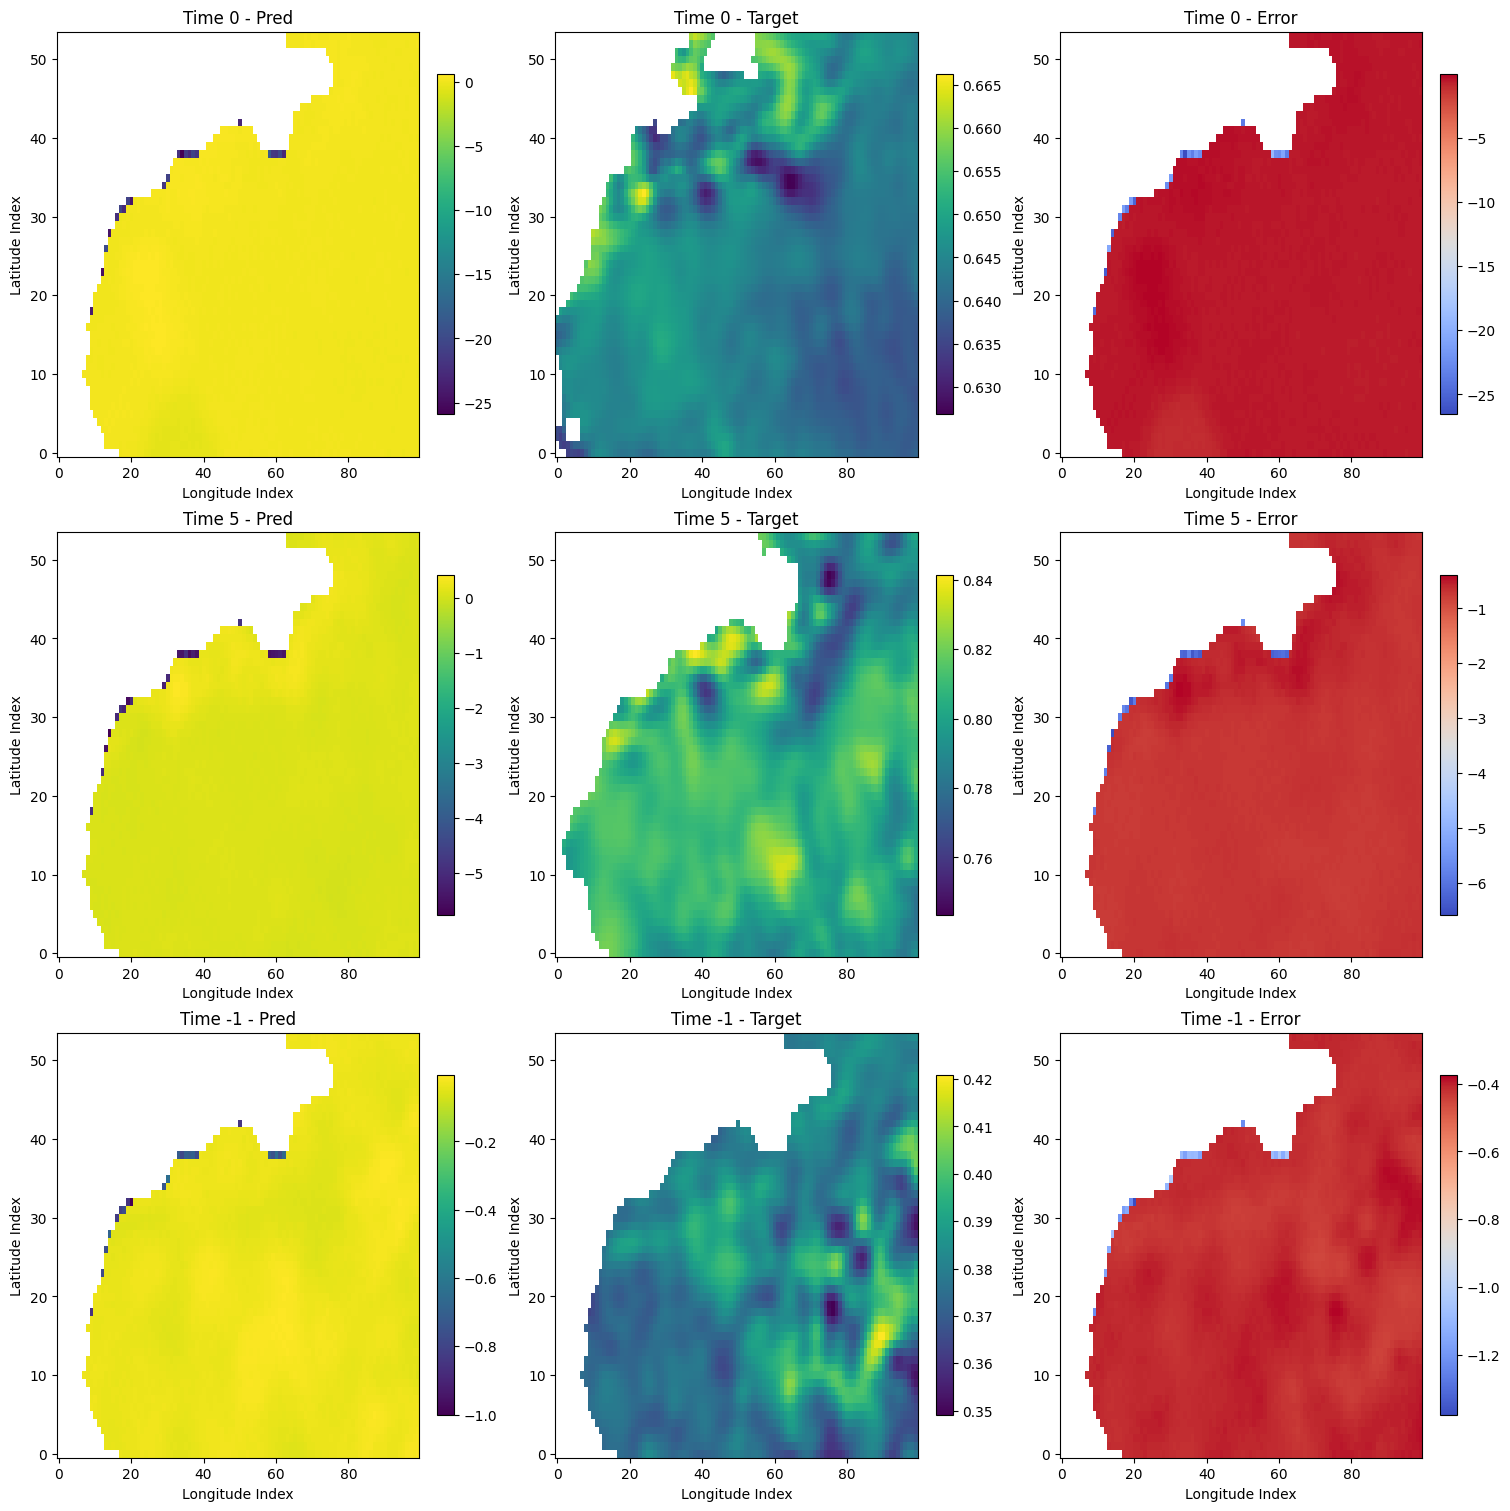

In [6]:
def plot_ocean_data(pred, target, indices):
    """
    绘制指定时刻的海洋数据子图，每个时刻绘制 pred、target 和误差。

    参数:
    - pred: 预测数据的三维数组，形状为 (112, 120, 280)
    - target: 真实数据的三维数组，形状为 (112, 120, 280)
    - indices: 要绘制的时刻索引列表（从0开始）

    返回:
    - 绘制的多个子图。
    """
    num_plots = len(indices) * 3  # 每个时刻绘制3个子图
    fig, axes = plt.subplots(len(indices), 3, figsize=(15, 5 * len(indices)), constrained_layout=True)
    
    # 如果只有一个时刻，axes 不是二维数组，需要调整
    if len(indices) == 1:
        axes = np.array([axes])

    # 遍历每个时刻
    for row, time_idx in enumerate(indices):
        # 绘制预测数据
        ax = axes[row, 0]
        im = ax.imshow(pred[time_idx, :, :], cmap='viridis', origin='lower', aspect='auto')
        ax.set_title(f'Time {time_idx} - Pred')
        ax.set_xlabel('Longitude Index')
        ax.set_ylabel('Latitude Index')
        plt.colorbar(im, ax=ax, shrink=0.8)

        # 绘制真实数据
        ax = axes[row, 1]
        im = ax.imshow(target[time_idx, :, :], cmap='viridis', origin='lower', aspect='auto')
        ax.set_title(f'Time {time_idx} - Target')
        ax.set_xlabel('Longitude Index')
        ax.set_ylabel('Latitude Index')
        plt.colorbar(im, ax=ax, shrink=0.8)

        # 绘制误差数据
        ax = axes[row, 2]
        error_data = pred[time_idx, :, :] - target[time_idx, :, :]
        im = ax.imshow(error_data, cmap='coolwarm', origin='lower', aspect='auto')
        ax.set_title(f'Time {time_idx} - Error')
        ax.set_xlabel('Longitude Index')
        ax.set_ylabel('Latitude Index')
        plt.colorbar(im, ax=ax, shrink=0.8)

    plt.show()

# 示例调用
# 假设 pred 和 target 是形状为 (112, 120, 280) 的随机数据
# pred = np.random.rand(112, 120, 280)
# target = np.random.rand(112, 120, 280)
indices = [0, 5, -1]  # 指定要绘制的时刻索引
print(pred.shape, targets.shape)
plot_ocean_data(pred, targets[0, ...], indices)

In [4]:
import yaml

# 读取YAML文件
with open('/home/pengguohang/python_test/Ocean/OceanBench2/config/ST_Gulf_Earthformer.yaml', 'r') as file:
    args = yaml.safe_load(file)

# 打印读取的数据
print(args)

device = torch.device(args['device'] if torch.cuda.is_available() else 'cpu')
predict(args)

{'challenge_name': 'S', 'if_training': True, 'continue_training': False, 'model_path': None, 'saved_dir': '/home/data2/pengguohang/My_Ocean/challenge/checkpoint/new_data', 'output_dir': './output/', 'save_period': 10, 'plot_interval': 1, 'device': 'cuda:6', 'seed': 0, 'epochs': 50, 'pat': 30, 'dataset': {'region_name': 'Gulf', 'folder_path': '/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/', 'label_path': '/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/label.nc', 'norm': True, 'seq_len': 5}, 'dataloader': {'train_bs': 2, 'val_bs': 1, 'test_bs': 1, 'num_workers': 0, 'pin_memory': False}, 'model': {'model_name': 'Earthformer', 'in_dim': 10, 'out_dim': 15, 'base_units': 64, 'downsample_scale': [1, 2, 2], 'activ': 'Sigmoid', 'noise': 0.0, 'xavier_init': 0.01, 'last_activation': True, 'dropout_fraction': 0.2, 'debug': False}, 'optimizer': {'name': 'Adam', 'lr': 0.001, 'weight_decay': 0.0001}, 'scheduler': {'name': 'StepLR', 'step_size': 20, 'gamma': 0.9}}
Shape of vari

/home/pengguohang/anaconda3/envs/py3.8/lib/python3.8/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([1, 15, 54, 100])


## 垂直分析

：201901不同深度的平均结果

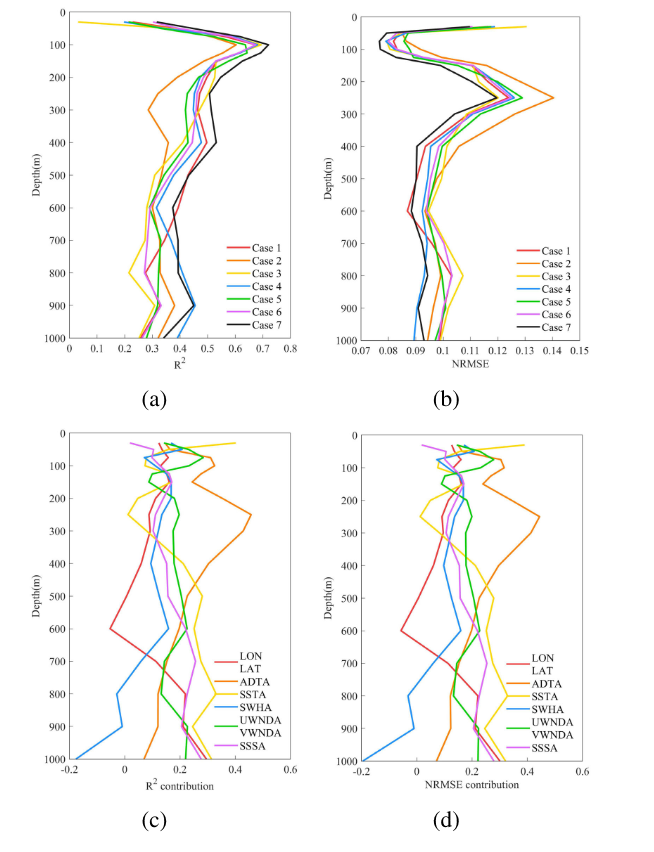
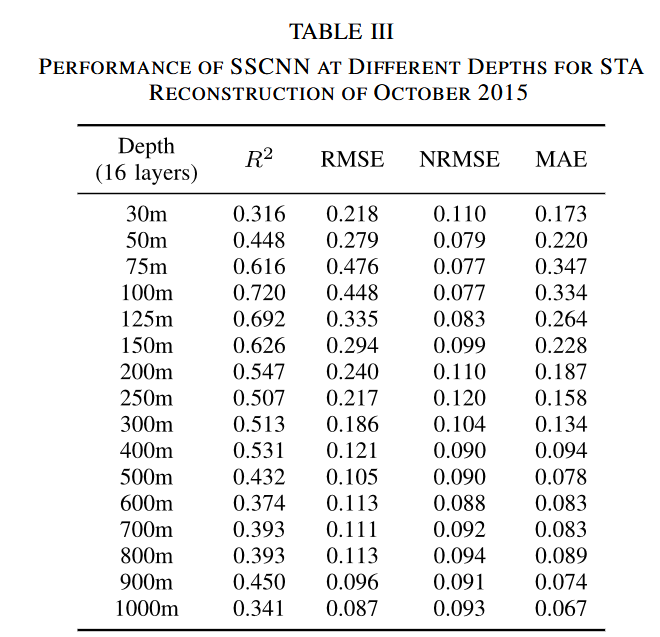

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_depth(pred_earthformer, pred_unet, pred_earthformer_new, pred_earthformer_kan, target, lat, lon):
    """
    计算2019年1月每个深度的某个地点的真实及预测值，并绘图

     - pred_earthformer, pred_unet, pred_earthformer_new, pred_earthformer_kan, target: 某月36个深度的预测值 torch.Size([36, 54, 100])
     - lat, lon: 某个地点的坐标

     - depth: [   1.,   10.,   30.,   70.,  100.,  150.,  200.,  300.,  400.,  500.,
         600.,  700.,  800.,  900., 1000.]
    """
    # 定义深度
    depth = [1, 10, 30, 70, 100, 150, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
    
    # 转换为NumPy数组
    # pred_earthformer = pred_earthformer.detach().cpu().numpy()
    # pred_unet = pred_unet.detach().cpu().numpy()
    # pred_earthformer_new = pred_earthformer_new.detach().cpu().numpy()
    # pred_earthformer_kan = pred_earthformer_kan.detach().cpu().numpy()
    # target = target.detach().cpu().numpy()
    
    # 提取指定经纬度的预测值
    pred_earthformer_val = pred_earthformer[:, lat, lon]
    pred_unet_val = pred_unet[:, lat, lon]
    pred_earthformer_new_val = pred_earthformer_new[:, lat, lon]
    pred_earthformer_kan_val = pred_earthformer_kan[:, lat, lon]
    target_val = target[:, lat, lon]
    
    # 绘图
    plt.figure(figsize=(10, 8))
    plt.plot(pred_earthformer_val, depth, label='Earthformer', marker='o', color='blue')
    plt.plot(pred_unet_val, depth, label='UNet', marker='o', color='green')
    plt.plot(pred_earthformer_new_val, depth, label='Earthformer New', marker='o', color='red')
    plt.plot(pred_earthformer_kan_val, depth, label='Earthformer Kan', marker='o', color='orange')
    plt.plot(target_val, depth, label='Earthformer Kan', marker='o', color='orange')
    
    # 添加图例和标签
    plt.legend()
    plt.xlabel('RMSE (°C)')
    plt.ylabel('Depth (m)')
    plt.title('RMSE vs Depth')
    
    # 显示图形
    plt.show()

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def plot_depth(pred_earthformer, pred_unet, pred_earthformer_new, pred_earthformer_kan, target, lat, lon):
    """
    绘制某个地点的真实温度及不同模型的预测温度随深度变化的曲线。
    
    Parameters:
    - pred_earthformer, pred_unet, pred_earthformer_new, pred_earthformer_kan, target: 预测值和真实值张量，形状为[深度数, 纬度数, 经度数]
    - lat, lon: 指定地点的纬度和经度索引
    """
    depth = [1., 10., 30., 70., 100., 150., 200., 300., 400., 500.,
             600., 700., 800., 900., 1000.]  # 深度列表（单位：米）

    # 提取各模型和目标在指定位置的值（假设输入为PyTorch张量）
    def extract_values(tensor):
        if hasattr(tensor, 'cpu'):
            tensor = tensor.cpu().numpy()
        return tensor[:, lat, lon]

    target_vals = extract_values(target)
    earthformer_vals = extract_values(pred_earthformer)
    unet_vals = extract_values(pred_unet)
    earthformer_new_vals = extract_values(pred_earthformer_new)
    earthformer_kan_vals = extract_values(pred_earthformer_kan)

    # 创建图表
    plt.figure(figsize=(8, 6))
    plt.gca().invert_yaxis()  # 反转纵轴，使深度向下递增

    # 绘制各模型的温度曲线
    plt.plot(earthformer_vals, depth, label='EarthFormer', marker='o', markersize=5, linestyle='-')
    plt.plot(unet_vals, depth, label='UNet', marker='s', markersize=5, linestyle='-')
    plt.plot(earthformer_new_vals, depth, label='EarthFormer_New', marker='^', markersize=5, linestyle='-')
    plt.plot(earthformer_kan_vals, depth, label='EarthFormer_KAN', marker='d', markersize=5, linestyle='-')
    plt.plot(target_vals, depth, label='Target', color='black', linestyle='--', linewidth=2, marker='x', markersize=7)

    # 设置标签和标题
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Depth (m)')
    plt.title(f'Temperature Profile at Latitude Index {lat}, Longitude Index {lon}')
    plt.yticks(depth)  # 显式设置纵轴刻度
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

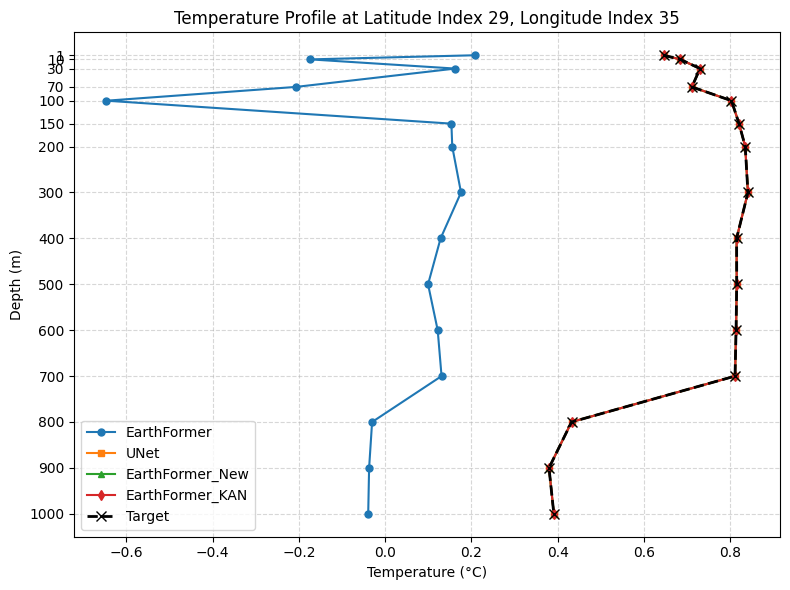

In [21]:
lat = 29
lon = 35
plot_depth(pred, targets[0, ...], targets[0, ...], targets[0, ...], targets[0, ...], lat, lon)

## 时序分析

绘制不同六个月份在不同深度的误差
(在整个研究区域的各个深度层上计算的平均值)

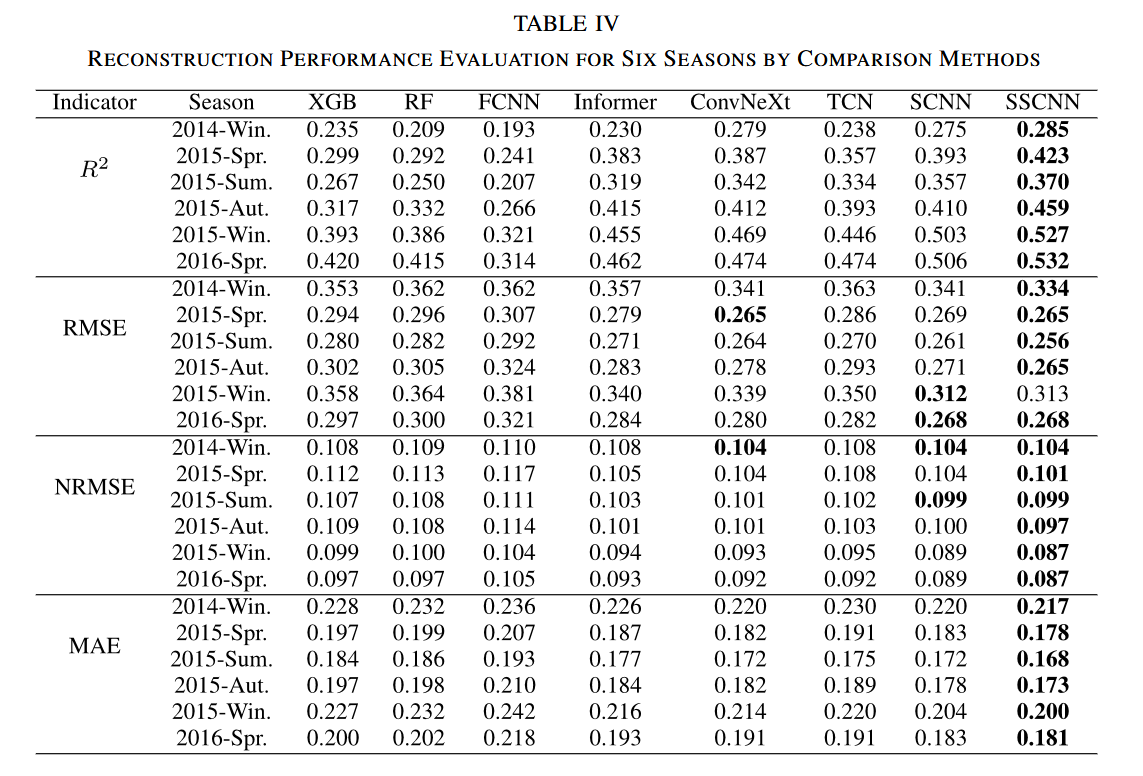

In [45]:
def predict_all_time(args, i):
     """
     
     pred: [time, depth, lat, lon]
     res: {'MSE': [time, depth], 'RMSE': [time, depth], 'MaxError': [time, depth], 'NRMSE': [time, depth], 'R2': [time, depth]}
     """
     # get data
     test_loader = get_testloader(args)
     data = list(test_loader)[-1]  # 取201901的数据来预测
     inputs = data[0]
     targets = data[1]
     mask = data[2]
     print('load: ', inputs.shape, targets.shape)

     # get model
     model = get_model(test_loader, args)
     model_name = args['model']['model_name']
     saved_model_name = args["challenge_name"] + '_' + args['dataset']['region_name'] + '_' + model_name
     saved_path = os.path.join(args['saved_dir'], saved_model_name)
     print(f"Test mode, load checkpoint from {saved_path}-best.pt")
     checkpoint = torch.load(saved_path + "-best.pt")
     model.load_state_dict(checkpoint["model_state_dict"])
     model.eval()

     # minmax
     label_min = torch.tensor([-22.3365, -10.7569,  -6.6964,  -4.4988,  -5.1653,  -5.1971,  -5.2404,
          -5.3556,  -5.4858,  -5.6206,  -5.7480,  -5.6085,  -0.9481,  -0.7738,
          -0.7684])
     label_max = torch.tensor([12.5375,  5.3539,  2.7673,  2.0444,  1.4409,  1.3003,  1.1856,  1.1887,
          1.4225,  1.4487,  1.4819,  1.4546,  1.4365,  1.3752,  1.2781])
     minmax = [label_min, label_max]

     metric_names=['MSE', 'RMSE', 'MaxError','NRMSE', 'R2']

     preds = []
     targets = []
     errors = {key: [] for key in metric_names}
     for inputs, target, mask in test_loader:
          # error[1, 1, 15]  pred[1, depth, lat, lon]
          error, pred, info = model.train_one_step(inputs, target, mask, minmax, calculate_res, metric_names)
          # pred 
          preds.append(pred.detach().numpy()[0])
          targets.append(target.detach().numpy()[0])
          for key in metric_names:
               errors[key].append(error[key].detach().numpy()[0, 0])
     preds = np.stack(preds, axis=0)
     targets = np.stack(targets, axis=0)
     for key in metric_names:
          errors[key] = np.stack(errors[key], axis=0)


     return preds, errors, targets

In [54]:
import yaml

# 读取YAML文件
with open('/home/pengguohang/python_test/Ocean/OceanBench2/train_pic/config/ST_Gulf_FNN.yaml', 'r') as file:
    args = yaml.safe_load(file)

# 打印读取的数据
print(args)

device = torch.device(args['device'] if torch.cuda.is_available() else 'cpu')
pred, res, targets = predict_all_time(args, 0)

print(res.keys())
print(pred.shape)
print(res['NRMSE'].shape)

{'challenge_name': 'S', 'if_training': True, 'continue_training': False, 'model_path': None, 'saved_dir': '/home/data2/pengguohang/My_Ocean/challenge/checkpoint/new_data', 'output_dir': './output/', 'save_period': 5, 'plot_interval': 1, 'device': 'cuda:7', 'seed': 0, 'epochs': 50, 'pat': 30, 'dataset': {'region_name': 'Gulf', 'folder_path': '/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/', 'label_path': '/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/label.nc', 'norm': True, 'seq_len': 0}, 'dataloader': {'train_bs': 2, 'val_bs': 1, 'test_bs': 1, 'num_workers': 0, 'pin_memory': False}, 'model': {'model_name': 'FNN', 'in_dim': 10, 'out_dim': 15, 'n_units1': 1000, 'n_units2': 1000, 'activ': 'Sigmoid', 'noise': 0.0, 'xavier_init': 0.01, 'last_activation': True, 'dropout_fraction': 0.2, 'debug': False}, 'optimizer': {'name': 'Adam', 'lr': 0.001, 'weight_decay': 0.0001}, 'scheduler': {'name': 'StepLR', 'step_size': 20, 'gamma': 0.9}}
Shape of variables: torch.Size([25,

In [76]:
# testloader中为199301-199312 201801-201901
# 取出2018年3 6 9 12月份的数据 代表四个季节
index = [15, 18, 21, 24]
pred_2019 = pred[index]
R2_2019 = res['R2'][index]
RMSE_2019 = res['RMSE'][index]
NRMSE_2019 = res['NRMSE'][index]
MSE_2019 = res['MSE'][index]
print(pred_2019.shape, R2_2019.shape, RMSE_2019.shape, NRMSE_2019.shape)

(4, 15, 54, 100) (4, 15) (4, 15) (4, 15)


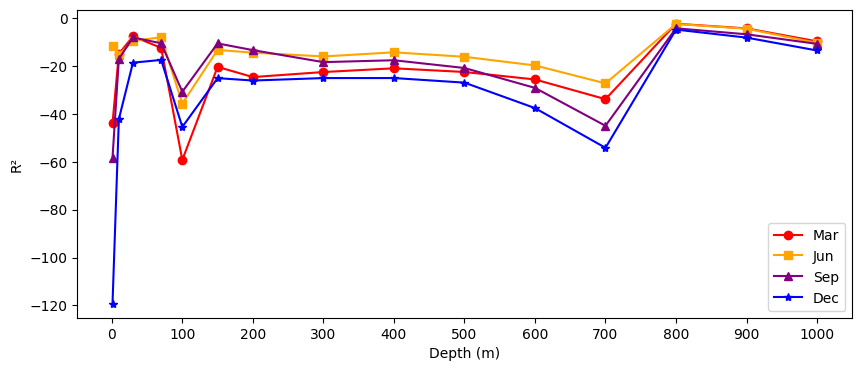

In [64]:
# 绘制图1：R2的季节变化
def plot_season1(R2):
    """
    绘制 R² 值随深度变化的折线图。

    参数:
    R2 -- 一个二维列表，包含每个月份在不同深度的 R² 值
    depth -- 一个列表，包含深度值
    months -- 一个列表，包含月份名称
    """
    # 绘制图像
    plt.figure(figsize=(10, 4))

    # 颜色和标记样式
    colors = ['red', 'orange', 'purple', 'blue']
    markers = ['o', 's', '^', '*']

    depth = [1., 10., 30., 70., 100., 150., 200., 300., 400., 500.,
             600., 700., 800., 900., 1000.]
    months = ['Mar', 'Jun', 'Sep', 'Dec']

    for i in range(len(R2)):
        plt.plot(depth, R2[i], label=months[i], color=colors[i], marker=markers[i])

    # 添加图例和标签
    plt.legend()
    plt.xlabel('Depth (m)')
    plt.ylabel('R²')

    # 去掉背景网格
    plt.grid(False)

    plt.xticks(range(0, 1001, 100))  # 每隔 50 米一个刻度

    # 显示图像
    plt.show()
    
plot_season1(R2_2019)

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

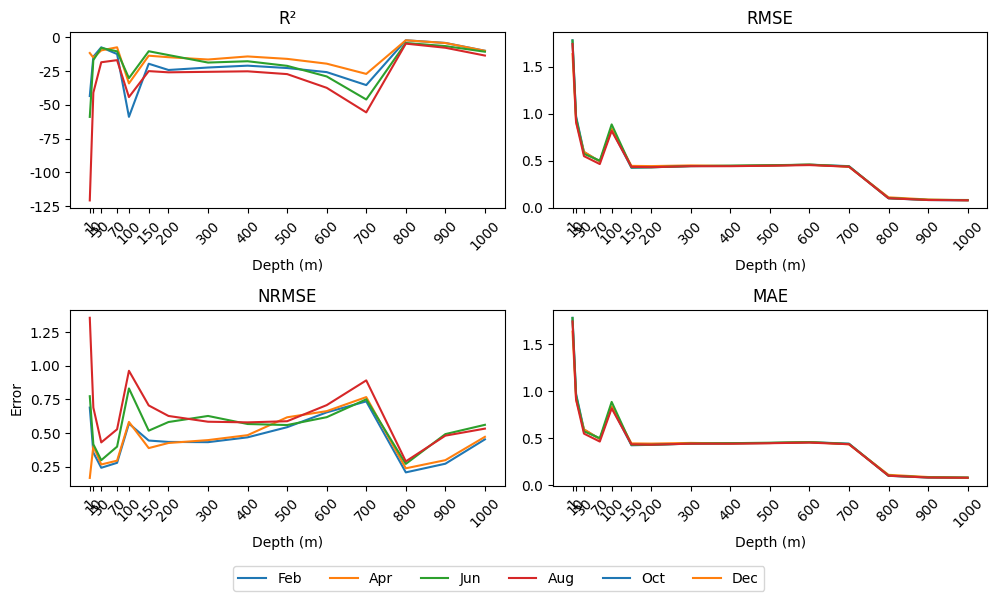

In [83]:
def plot_metrics_depth(R2, RMSE, NRMSE, MAE):
    """
    绘制 R²、RMSE、NRMSE 和 MAE 随深度变化的折线图。
    
    参数：
    R2, RMSE, NRMSE, MAE: (6, N) 形状的 numpy 数组，表示 6 个月的数据。
    depth: (N,) 长度的列表或数组，表示深度。
    """
    depth = np.array([1, 10, 30, 70, 100, 150, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
    months = ['Feb', 'Apr', 'Jun', 'Aug', 'Oct', 'Dec']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 6))
    metrics = [(R2, "R²"), (RMSE, "RMSE"), (NRMSE, "NRMSE"), (MAE, "MAE")]

    # 选取 15 个均匀分布的位置，但实际标签仍然使用 depth 对应的值
    depth_indices = np.linspace(0, len(depth) - 1, 15, dtype=int)
    depth_ticks = np.array(depth)[depth_indices]  # 获取对应的深度值

    for ax, (metric, title) in zip(axes.flat, metrics):
        for i in range(4):
            ax.plot(depth, metric[i], label=months[i], color=colors[i])
        ax.set_title(title)
        ax.set_xlabel("Depth (m)")
        ax.set_xticks(depth_ticks)  # 均匀放置 15 个深度
        ax.set_xticklabels(depth_ticks, rotation=45)  # 旋转标签以便更好地显示
    
    axes[1, 0].set_ylabel("Error")  # 统一 Y 轴标签
    
    fig.legend(months, loc='lower center', ncol=6)
    fig.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()

plot_metrics_depth(R2_2019, RMSE_2019, NRMSE_2019, RMSE_2019)

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

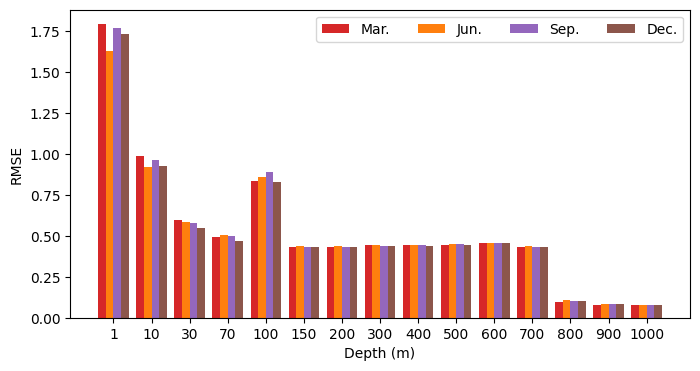

In [74]:
def plot_season2(RMSE):
    """
    绘制 RMSE 随深度变化的柱状图。
    
    参数：
    RMSE: (4, 15) 形状的 numpy 数组，表示 3 月、6 月、9 月、12 月的 RMSE。
    depth: (15,) 长度的列表或数组，表示深度。
    """
    depth = np.array([1, 10, 30, 70, 100, 150, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
    months = ['Mar.', 'Jun.', 'Sep.', 'Dec.']
    colors = ['#d62728', '#ff7f0e', '#9467bd', '#8c564b']  # 调整颜色以降低对比度
    bar_width = 0.2
    
    x = np.arange(len(depth))  # 横轴索引
    
    plt.figure(figsize=(8, 4))
    for i in range(4):
        plt.bar(x + i * bar_width, RMSE[i], width=bar_width, color=colors[i], label=months[i])
    
    plt.xticks(x + 1.5 * bar_width, depth)  # 调整刻度位置
    plt.xlabel("Depth (m)")
    plt.ylabel("RMSE")
    
    plt.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=4)  # 设置标识为一行，放在右上角
    plt.show()

plot_season2(RMSE_2019)

## 其他

In [47]:
def plot_res(res_1, res_2, res_3, res_4, res_5, res_6, name):
    """
    计算2019年1月每个深度的某个地点的真实及预测值，并绘图

    pred: torch.Size([36])
    target: torch.Size([36])

    FNN LSTM UNET Earthformer IMLP AT_GRU

    plot
    """
    depth = [   1.,   10.,   30.,   70.,  100.,  150.,  200.,  300.,  400.,  500.,
         600.,  700.,  800.,  900., 1000.]
    depth = [-x for x in depth]
    

    # Sample data for demonstration (replace this with actual data)
    res1 = res_1
    res2 = res_2
    res3 = res_3
    res4 = res_4
    res5 = res_5
    res6 = res_6

    # Create subplots
    fig, ax = plt.subplots(figsize=(6, 8))

    # Plotting all cases (replace with your actual data)
    # def plot_nitrate_profile(ax, title):
#     print(unet, earthformer)
    ax.plot(res1, depth, label="FNN", color='#736bba')
    ax.plot(res2, depth, label="LSTM", color='#7edace')
    ax.plot(res3, depth, label="UNET", color='#d5dca2')
    ax.plot(res4, depth, label="Earthformer", color='#86b47a')
    ax.plot(res5, depth, label="IMLP", color='#a753a1')
    ax.plot(res6, depth, label="AT_GRU", color='black')

    ax.legend()
    
    ax.set_xscale('log')
    ax.set_xlabel(name)
    ax.set_ylabel("Depth (m)")
    ax.set_title("(a)")

    ax.set_xlim([0, 0.3])
    ax.set_ylim([-1000, 0])
    ax.grid(True)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

In [62]:
import ast

# 读取 CSV 文件路径
file_path = "/home/pengguohang/python_test/Ocean/OceanBench2/results_Pacific.csv"

# 读取 CSV 文件（假设有标题行）
data = pd.read_csv(file_path)

# 初始化结果存储字典
result = {}

# 遍历 CSV 文件内容
for _, row in data.iterrows():
    model_name = row['Model Name']
    metric = row['Metric Name']
    average_value = float(row['Average Value'])
    
    try:
        depth_values = ast.literal_eval(row['Depth Values'])  # 尝试解析深度值
    except (ValueError, SyntaxError):
        depth_values = None  # 如果解析失败，跳过

    # 检查模型是否已在结果字典中
    if model_name not in result:
        result[model_name] = {}  # 初始化模型条目

    # 添加指标数据
    result[model_name][metric] = {
        "Average Value": average_value,
        "Depth Values": depth_values
    }

# 打印解析结果
for model, metrics in result.items():
    print(f"Model: {model}")
    for metric, values in metrics.items():
        print(f"  Metric: {metric}")
        print(f"    Average Value: {values['Average Value']}")
        print(f"    Depth Values: {values['Depth Values']}")


Model: FNN
  Metric: MSE
    Average Value: 4.352718679001555e-05
    Depth Values: [[[1.1571039976843167e-05, 4.1704290197230875e-05, 8.545975288143381e-05, 0.00010239615221507847, 8.985164458863437e-05, 0.00013494527956936508, 0.0001258825941476971, 2.7872032660525292e-05, 1.072935265256092e-05, 4.045282366860192e-06, 2.408197360637132e-06, 1.7612429701330257e-06, 5.407174739957554e-06, 5.059177510702284e-06, 3.814550609604339e-06]]]
  Metric: RMSE
    Average Value: 0.0052731623873114
    Depth Values: [[[0.0033280227798968554, 0.006356127094477415, 0.009119314141571522, 0.009972332045435905, 0.0092287827283144, 0.011123423464596272, 0.010564456693828106, 0.005103462841361761, 0.003177991835400462, 0.0019750073552131653, 0.0015085458289831877, 0.0012773838825523853, 0.002249400829896331, 0.002198196016252041, 0.0019149873405694962]]]
  Metric: MaxError
    Average Value: 0.108102262020111
    Depth Values: [[[0.026842057704925537, 0.06359261274337769, 0.09387439489364624, 0.06559473

In [63]:
res_1 = np.array(result['FNN']['NRMSE']['Average Value'])
res_2 =  np.array(result['LSTM']['NRMSE']['Average Value'])
res_3 =  np.array(result['Earthformer']['NRMSE']['Average Value'])
res_4 =  np.array(result['UNET']['NRMSE']['Average Value'])
res_5 =  np.array(result['MLPE']['NRMSE']['Average Value'])
print(res_5)
res_6 =  np.array(result['AT_GRU']['NRMSE']['Average Value'])
print(res_6)

0.0153035288676619
0.1485148966312408


In [64]:
res_1 = np.array(result['FNN']['NRMSE']['Depth Values'][0][0])
res_2 =  np.array(result['LSTM']['NRMSE']['Depth Values'][0][0])
res_3 =  np.array(result['Earthformer']['NRMSE']['Depth Values'][0][0])
res_4 =  np.array(result['UNET']['NRMSE']['Depth Values'][0][0])
res_5 =  np.array(result['MLPE']['NRMSE']['Depth Values'][0][0])
print(res_5)
res_6 =  np.array(result['AT_GRU']['NRMSE']['Depth Values'][0][0])
print(res_6)

[0.01142287 0.01526884 0.02004287 0.02077339 0.02011497 0.02493743
 0.0242028  0.01706887 0.01409022 0.01388846 0.01380196 0.01383677
 0.00690552 0.00692362 0.00627434]
[0.13661848 0.1399107  0.13551569 0.14747179 0.14142798 0.11912091
 0.11541948 0.11017951 0.11298306 0.11338609 0.11250494 0.11159065
 0.23192839 0.25492033 0.24474522]


/tmp/ipykernel_1613431/3361522316.py:45: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim([0, 0.3])


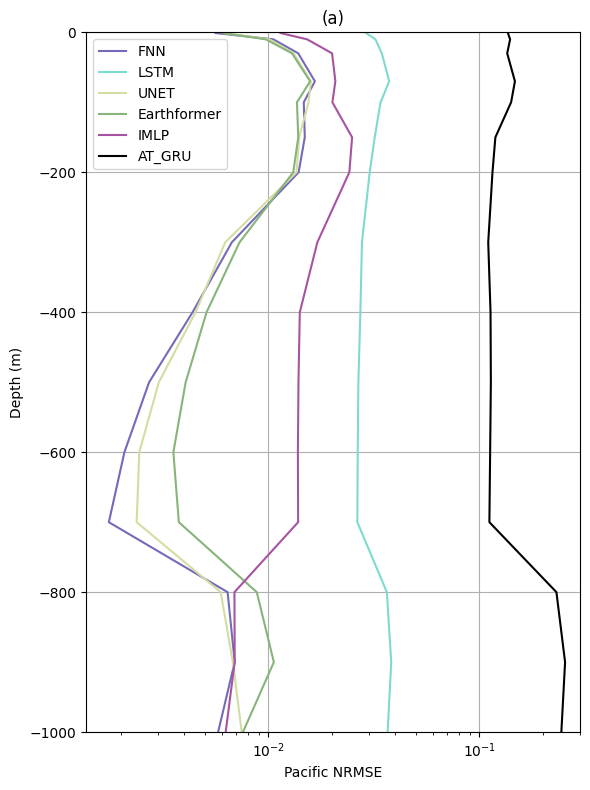

In [65]:
name = 'Pacific NRMSE'
plot_res(res_1, res_2, res_3, res_4, res_5, res_6, name)

[0.05707317 0.07230047 0.0456424  0.05298348 0.04833644 0.06143848
 0.03377931 0.05217658 0.04403264 0.04568456 0.04701978 0.05509154
 0.03136138 0.04288593 0.03222655 0.04514825 0.07218138 0.05849964
 0.03368852 0.02941938 0.0352113  0.03802916 0.04194185 0.06546923
 0.05651755 0.03491846] [0.04872776 0.0467895  0.03817562 0.03205452 0.02883623 0.02680526
 0.02417141 0.0204744  0.01788448 0.01540686 0.0138262  0.01261611
 0.01253286 0.01191592 0.01154369 0.01033578 0.01093813 0.01030877
 0.01169256 0.00829809 0.00767299 0.00734685 0.0063453  0.00634939
 0.0073942  0.00604833]


/tmp/ipykernel_314414/477330435.py:39: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim([0, 0.1])


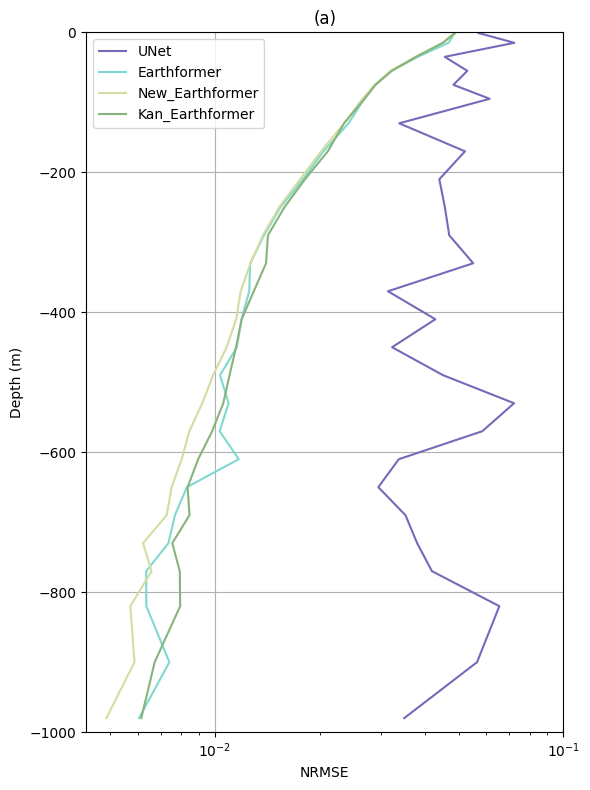

In [18]:
plot_res(res_depth_unet['NRMSE'][0], res_depth_earthformer['NRMSE'][0], res_depth_earthformer_new['NRMSE'][0], res_depth_earthformer_kan['NRMSE'][0])

## 计算春夏秋冬的误差均值

201801-03 201804-06 201807-09 201810-12

In [19]:
# UNET的误差均值
def compute_season(preds, targets, model_name):
    '''
    preds: [time, depth, lat, lon] 
    targets: [time, depth, lat, lon] 
    '''
    i = 13  # 测试集共有25个月份，从13个开始为2018年
    res = {}
    for name in ['spr', 'sum', 'aut', 'win']:
        pred = preds[i:i+3].reshape((3, 26, -1))
        target = targets[i:i+3].reshape((3, 26, -1))  # [3, depth, lat*lon]

        res_season = calculate_res(pred, target, ['MSE', 'RMSE', 'NRMSE', 'MaxError', 'R2'])
        for metric in res_season.keys():
            res_season[metric] = res_season[metric].mean()

        res[name] = res_season

        i += 3

    # Write results to CSV
    output_path = os.path.join('./', 'season_results.csv')
    with open(output_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        # Write header row
        writer.writerow([model_name, "MSE", "RMSE", "NRMSE", "MaxError", "R2"])

        # Write data for each season
        for season, metrics in res.items():
            row = [model_name, season] + [metrics[metric].item() for metric in ["MSE", "RMSE", "NRMSE", "MaxError", "R2"]]
            writer.writerow(row)


    print(f"Seasonal results written to {output_path}")
    
    return res 

In [20]:
print(len(preds_earthformer), preds_earthformer[0].shape,len(output_targets), output_targets[0].shape)

25 [1, 1, 180, 360, 26] 25 [1, 26, 180, 360]


In [21]:
# earthformer
preds = paddle.concat(preds_earthformer, axis=0)[:, 0, :, :, :].transpose((0, 3, 1, 2))

targets = paddle.concat(output_targets, axis=0) 
print(preds.shape, targets.shape)
targets = targets * (label_max - label_min) + label_min  # 逆归一化

print(targets.shape, mask_y.shape)  
targets = paddle.where(mask_y, targets, 0.0)  # 掩码处理
preds = paddle.where(mask_y, preds, 0.0)

print(preds.shape, targets.shape)

res_all = compute_season(preds, targets, 'Earthformer')
print(res_all)

[25, 26, 180, 360] [25, 26, 180, 360]
[25, 26, 180, 360] [26, 180, 360]
[25, 26, 180, 360] [25, 26, 180, 360]
Seasonal results written to ./season_results.csv
{'spr': {'MSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.00311832), 'RMSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.04557915), 'NRMSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.01980785), 'MaxError': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.72103014), 'R2': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.99952372)}, 'sum': {'MSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.00303549), 'RMSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.04512903), 'NRMSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.01960697), 'MaxError': Tensor(sh

In [22]:
# earthformer_new
preds = paddle.concat(preds_earthformer_new, axis=0)[:, 0, :, :, :].transpose((0, 3, 1, 2))

targets = paddle.concat(output_targets, axis=0) 
print(preds.shape, targets.shape)
targets = targets * (label_max - label_min) + label_min  # 逆归一化

print(targets.shape, mask_y.shape)  
targets = paddle.where(mask_y, targets, 0.0)  # 掩码处理
preds = paddle.where(mask_y, preds, 0.0)

print(preds.shape, targets.shape)

res_all = compute_season(preds, targets, 'Earthformer_new')
print(res_all)

[25, 26, 180, 360] [25, 26, 180, 360]
[25, 26, 180, 360] [26, 180, 360]
[25, 26, 180, 360] [25, 26, 180, 360]
Seasonal results written to ./season_results.csv
{'spr': {'MSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.00300725), 'RMSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.04410305), 'NRMSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.01916684), 'MaxError': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.71012509), 'R2': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.99954067)}, 'sum': {'MSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.00293633), 'RMSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.04359984), 'NRMSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.01894277), 'MaxError': Tensor(sh

In [23]:
# earthformer_kan
preds = paddle.concat(preds_earthformer_kan, axis=0)[:, 0, :, :, :].transpose((0, 3, 1, 2))

targets = paddle.concat(output_targets, axis=0) 
print(preds.shape, targets.shape)
targets = targets * (label_max - label_min) + label_min  # 逆归一化

print(targets.shape, mask_y.shape)  
targets = paddle.where(mask_y, targets, 0.0)  # 掩码处理
preds = paddle.where(mask_y, preds, 0.0)

print(preds.shape, targets.shape)

res_all = compute_season(preds, targets, 'Earthformer_kan')
print(res_all)

[25, 26, 180, 360] [25, 26, 180, 360]
[25, 26, 180, 360] [26, 180, 360]
[25, 26, 180, 360] [25, 26, 180, 360]
Seasonal results written to ./season_results.csv
{'spr': {'MSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.00311452), 'RMSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.04597645), 'NRMSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.01998054), 'MaxError': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.70920003), 'R2': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.99952428)}, 'sum': {'MSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.00301333), 'RMSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.04502665), 'NRMSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.01956262), 'MaxError': Tensor(sh

In [24]:
# unet
preds = paddle.concat(preds_unet, axis=0)

targets = paddle.concat(output_targets, axis=0) 
print(preds.shape, targets.shape)
targets = targets * (label_max - label_min) + label_min  # 逆归一化

print(targets.shape, mask_y.shape)  
targets = paddle.where(mask_y, targets, 0.0)  # 掩码处理
preds = paddle.where(mask_y, preds, 0.0)

print(preds.shape, targets.shape)

res_all = compute_season(preds, targets, 'UNet')
print(res_all)

[25, 26, 180, 360] [25, 26, 180, 360]
[25, 26, 180, 360] [26, 180, 360]
[25, 26, 180, 360] [25, 26, 180, 360]
Seasonal results written to ./season_results.csv
{'spr': {'MSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.01341100), 'RMSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.11201419), 'NRMSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.04866715), 'MaxError': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       1.58876099), 'R2': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.99795169)}, 'sum': {'MSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.01329639), 'RMSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.11146911), 'NRMSE': Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       0.04842944), 'MaxError': Tensor(sh

## Depth

In [25]:
import xarray as xr
path = '/home/data2/pengguohang/My_Ocean/CMEMS/CORA_1993_2019_P1M/CORA_199301_201901_PSAL_P1M.nc'
ds = xr.open_dataset(path)
# label = ds['label'].values
# label_1 = label[0, ...]

# print(ds)
DEPTH = ds['depth'].values
print(DEPTH)
print(DEPTH[0:-1:4])  
# 取26个不同的深度层
# 记录下最大最小值，结果反归一化

# plot_temperature_at_depth(label_1, i=1) 

[   1.    3.    5.   10.   15.   20.   25.   30.   35.   40.   45.   50.
   55.   60.   65.   70.   75.   80.   85.   90.   95.  100.  110.  120.
  130.  140.  150.  160.  170.  180.  190.  200.  210.  220.  230.  240.
  250.  260.  270.  280.  290.  300.  310.  320.  330.  340.  350.  360.
  370.  380.  390.  400.  410.  420.  430.  440.  450.  460.  470.  480.
  490.  500.  510.  520.  530.  540.  550.  560.  570.  580.  590.  600.
  610.  620.  630.  640.  650.  660.  670.  680.  690.  700.  710.  720.
  730.  740.  750.  760.  770.  780.  790.  800.  820.  840.  860.  880.
  900.  920.  940.  960.  980. 1000.]
[  1.  15.  35.  55.  75.  95. 130. 170. 210. 250. 290. 330. 370. 410.
 450. 490. 530. 570. 610. 650. 690. 730. 770. 820. 900. 980.]
